# VAE Evaluation Notebook

This notebook evaluates the trained VAE model on the test set and generates detailed visualizations.

**Outputs:**
- Test set metrics (ELBO, MSE, MAE, RMSE in both normalized and original IV space)
- Mean error heatmap across all test samples
- Best and worst reconstructions
- Latent space visualization (PCA)
- Saved surfaces for comparison with Heston model

---

## 1. Setup and Configuration

In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from src.data.dataloaders import create_dataloaders
from src.models.vae_mlp import MLPVAE
from src.utils.eval import (
    evaluate_vae,
    compute_per_cell_error,
    get_worst_reconstructions,
    get_best_reconstructions,
    DetailedEvalResult,
)

# Enable inline plots
%matplotlib inline
plt.rcParams['figure.dpi'] = 100

In [2]:
# === Configuration ===
# Use vae_checkpoint.pt (contains args, input_shape, scaler) not best_model.pt
CHECKPOINT_PATH = "../../artifacts/train/vae_checkpoint.pt"
PARQUET_PATH = "../../data/processed/vae/parquet/AAPL_vsurf_processed.parquet"
OUTPUT_DIR = "../../artifacts/eval"

# Number of best/worst samples to visualize
N_PLOT_SAMPLES = 5

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


## 2. Load Checkpoint and Model

In [3]:
# Create output directories
output_dir = Path(OUTPUT_DIR)
output_dir.mkdir(parents=True, exist_ok=True)
plots_dir = output_dir / "plots"
plots_dir.mkdir(exist_ok=True)
surfaces_dir = output_dir / "surfaces"
surfaces_dir.mkdir(exist_ok=True)

# Load checkpoint
print(f"Loading checkpoint: {CHECKPOINT_PATH}")
checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE, weights_only=False)

train_args = checkpoint["args"]
input_shape = tuple(checkpoint["input_shape"])

print(f"Training args: {train_args}")
print(f"Input shape: {input_shape}")

Loading checkpoint: ../../artifacts/train/vae_checkpoint.pt
Training args: {'parquet': 'data/processed/vae/parquet/AAPL_vsurf_processed.parquet', 'value_col': 'impl_volatility', 'train_ratio': 0.8, 'val_ratio': 0.1, 'latent_dim': 8, 'hidden_dims': [256, 128], 'epochs': 100, 'batch_size': 32, 'lr': 0.001, 'beta': 1.0, 'patience': None, 'normalize': True, 'output_dir': 'artifacts/train', 'device': 'cuda'}
Input shape: (2, 11, 17)


In [4]:
# Recreate dataloaders with same config
print(f"Loading data from: {PARQUET_PATH}")
bundle = create_dataloaders(
    parquet_path=PARQUET_PATH,
    value_col=train_args.get("value_col", "impl_volatility"),
    train_ratio=train_args.get("train_ratio", 0.80),
    val_ratio=train_args.get("val_ratio", 0.10),
    batch_size=train_args.get("batch_size", 32),
    normalize=train_args.get("normalize", True),
    return_date=True,  # Need dates for plotting
)

print(f"\nDataset sizes:")
print(f"  Train: {len(bundle.train_dates)} samples")
print(f"  Val:   {len(bundle.val_dates)} samples")
print(f"  Test:  {len(bundle.test_dates)} samples")

Loading data from: ../../data/processed/vae/parquet/AAPL_vsurf_processed.parquet

Dataset sizes:
  Train: 1943 samples
  Val:   242 samples
  Test:  244 samples


In [5]:
# Recreate model
model = MLPVAE(
    in_shape=input_shape,
    latent_dim=train_args.get("latent_dim", 8),
    hidden_dims=tuple(train_args.get("hidden_dims", [256, 128])),
)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(DEVICE)
model.eval()

print(f"Model loaded successfully")
print(f"  Latent dim: {model.latent_dim}")
print(f"  Encoder layers: {model.encoder}")

Model loaded successfully
  Latent dim: 8
  Encoder layers: Sequential(
  (0): Linear(in_features=374, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
)


## 3. Run Evaluation on Test Set

In [6]:
# Run detailed evaluation
print("Running detailed evaluation on test set...")
result: DetailedEvalResult = evaluate_vae(
    model=model,
    loader=bundle.test_loader,
    device=DEVICE,
    beta=train_args.get("beta", 1.0),
    scaler=bundle.scaler,
    collect_details=True,
)

metrics = result.metrics
print("Evaluation complete!")

Running detailed evaluation on test set...
Evaluation complete!


In [7]:
# Display test metrics
print("=" * 50)
print("TEST SET METRICS")
print("=" * 50)
print(f"ELBO (total loss):     {metrics.elbo:.6f}")
print(f"Reconstruction loss:   {metrics.recon_loss:.6f}")
print(f"KL divergence:         {metrics.kl_loss:.6f}")
print(f"MSE (normalized):      {metrics.mse:.6f}")
print(f"MAE (normalized):      {metrics.mae:.6f}")
print(f"RMSE (normalized):     {metrics.rmse:.6f}")

if metrics.mse_original is not None:
    print("-" * 50)
    print("Metrics in original IV space:")
    print(f"MSE (original):        {metrics.mse_original:.6f}")
    print(f"MAE (original):        {metrics.mae_original:.6f}")
    print(f"RMSE (original):       {metrics.rmse_original:.6f}")
    print(f"MAE (vol points):      {metrics.mae_original * 100:.2f}%")
print("=" * 50)

TEST SET METRICS
ELBO (total loss):     0.301795
Reconstruction loss:   0.187694
KL divergence:         0.114101
MSE (normalized):      0.187694
MAE (normalized):      0.303661
RMSE (normalized):     0.433236
--------------------------------------------------
Metrics in original IV space:
MSE (original):        0.001039
MAE (original):        0.022585
RMSE (original):       0.032240
MAE (vol points):      2.26%


In [8]:
# Save metrics to JSON
metrics_path = output_dir / "test_metrics.json"
metrics.to_json(metrics_path)
print(f"Metrics saved to: {metrics_path}")

Metrics saved to: ..\..\artifacts\eval\test_metrics.json


## 4. Prepare Data for Visualization

In [9]:
# Grid specifications
days_grid = bundle.grid_spec.days_grid
delta_grid = bundle.grid_spec.delta_grid
cp_order = bundle.grid_spec.cp_order

print(f"Grid specifications:")
print(f"  Days:   {days_grid}")
print(f"  Deltas: {delta_grid}")
print(f"  CP:     {cp_order}")

Grid specifications:
  Days:   [ 10.  30.  60.  91. 122. 152. 182. 273. 365. 547. 730.]
  Deltas: [0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85 0.9 ]
  CP:     ['C', 'P']


In [10]:
# Get reconstructions in original space if scaler exists
if bundle.scaler is not None:
    recons_orig = bundle.scaler.inverse_transform(result.all_recons)
    targets_orig = bundle.scaler.inverse_transform(result.all_targets)
    errors_orig = torch.abs(recons_orig - targets_orig)
else:
    recons_orig = result.all_recons
    targets_orig = result.all_targets
    errors_orig = result.all_errors

print(f"Reconstructions shape: {recons_orig.shape}")
print(f"Targets shape: {targets_orig.shape}")

Reconstructions shape: torch.Size([244, 2, 11, 17])
Targets shape: torch.Size([244, 2, 11, 17])


## 5. Mean Error Heatmap

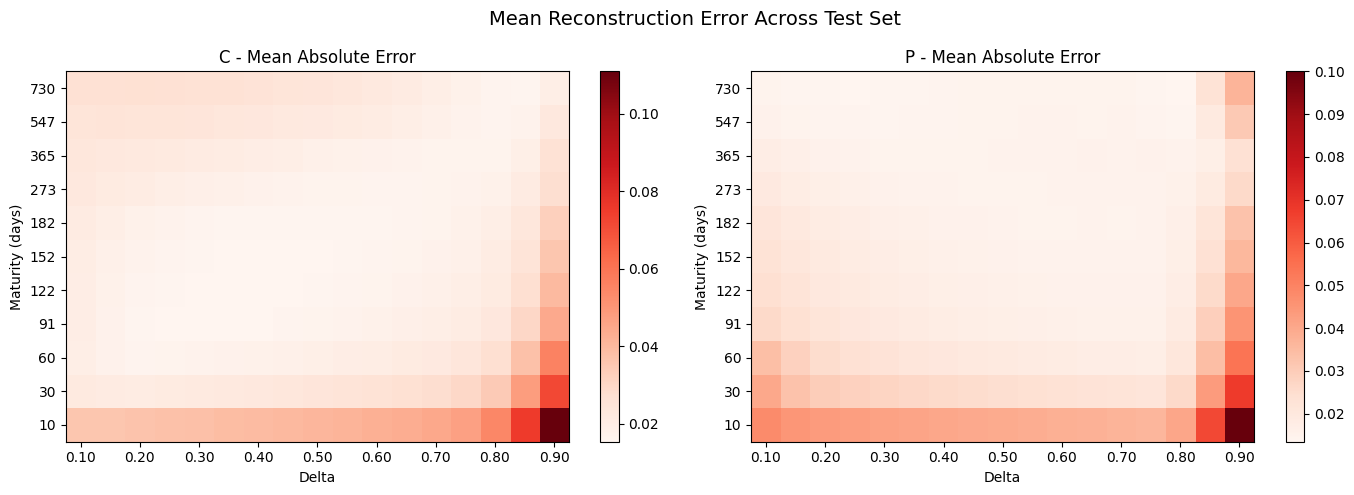

In [11]:
# Compute mean error across all test samples
mean_error = compute_per_cell_error(errors_orig, reduction="mean").numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for c, cp in enumerate(cp_order):
    im = axes[c].imshow(mean_error[c], aspect='auto', origin='lower', cmap='Reds')
    axes[c].set_title(f'{cp} - Mean Absolute Error', fontsize=12)
    axes[c].set_ylabel('Maturity (days)')
    axes[c].set_xlabel('Delta')
    axes[c].set_yticks(range(len(days_grid)))
    axes[c].set_yticklabels([int(d) for d in days_grid])
    axes[c].set_xticks(range(0, len(delta_grid), 2))
    axes[c].set_xticklabels([f'{d:.2f}' for d in delta_grid[::2]])
    plt.colorbar(im, ax=axes[c])

fig.suptitle('Mean Reconstruction Error Across Test Set', fontsize=14)
plt.tight_layout()
plt.savefig(plots_dir / "mean_error_heatmap.png", dpi=150, bbox_inches='tight')
plt.show()

## 6. Best Reconstructions

In [12]:
def plot_surface_comparison(
    target: np.ndarray,
    recon: np.ndarray,
    error: np.ndarray,
    days_grid: np.ndarray,
    delta_grid: np.ndarray,
    cp_order: list,
    title: str,
):
    """Plot comparison: original vs reconstructed vs error for both calls and puts."""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    for c, cp in enumerate(cp_order):
        row = c
        
        # Original
        im1 = axes[row, 0].imshow(target[c], aspect='auto', origin='lower', cmap='viridis')
        axes[row, 0].set_title(f'{cp} - Original IV')
        axes[row, 0].set_ylabel('Maturity (days)')
        axes[row, 0].set_xlabel('Delta')
        axes[row, 0].set_yticks(range(len(days_grid)))
        axes[row, 0].set_yticklabels([int(d) for d in days_grid])
        axes[row, 0].set_xticks(range(0, len(delta_grid), 2))
        axes[row, 0].set_xticklabels([f'{d:.2f}' for d in delta_grid[::2]])
        plt.colorbar(im1, ax=axes[row, 0])
        
        # Reconstructed
        im2 = axes[row, 1].imshow(recon[c], aspect='auto', origin='lower', cmap='viridis')
        axes[row, 1].set_title(f'{cp} - Reconstructed IV')
        axes[row, 1].set_xlabel('Delta')
        axes[row, 1].set_yticks(range(len(days_grid)))
        axes[row, 1].set_yticklabels([int(d) for d in days_grid])
        axes[row, 1].set_xticks(range(0, len(delta_grid), 2))
        axes[row, 1].set_xticklabels([f'{d:.2f}' for d in delta_grid[::2]])
        plt.colorbar(im2, ax=axes[row, 1])
        
        # Error heatmap
        im3 = axes[row, 2].imshow(error[c], aspect='auto', origin='lower', cmap='Reds')
        axes[row, 2].set_title(f'{cp} - Absolute Error')
        axes[row, 2].set_xlabel('Delta')
        axes[row, 2].set_yticks(range(len(days_grid)))
        axes[row, 2].set_yticklabels([int(d) for d in days_grid])
        axes[row, 2].set_xticks(range(0, len(delta_grid), 2))
        axes[row, 2].set_xticklabels([f'{d:.2f}' for d in delta_grid[::2]])
        plt.colorbar(im3, ax=axes[row, 2])
    
    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    return fig

In [13]:
# Get indices of best reconstructions
best_idx = get_best_reconstructions(result, k=N_PLOT_SAMPLES)

print(f"Best {N_PLOT_SAMPLES} reconstructions (by MSE):")
for i, idx in enumerate(best_idx):
    date_str = str(result.dates[idx])[:10] if result.dates is not None else f"sample_{idx}"
    mse = torch.mean(result.all_errors[idx] ** 2).item()
    print(f"  {i+1}. {date_str} (MSE: {mse:.6f})")

Best 5 reconstructions (by MSE):
  1. 2025-05-29 (MSE: 0.024417)
  2. 2025-02-07 (MSE: 0.023750)
  3. 2024-12-10 (MSE: 0.054184)
  4. 2024-11-08 (MSE: 0.058645)
  5. 2024-11-04 (MSE: 0.048913)


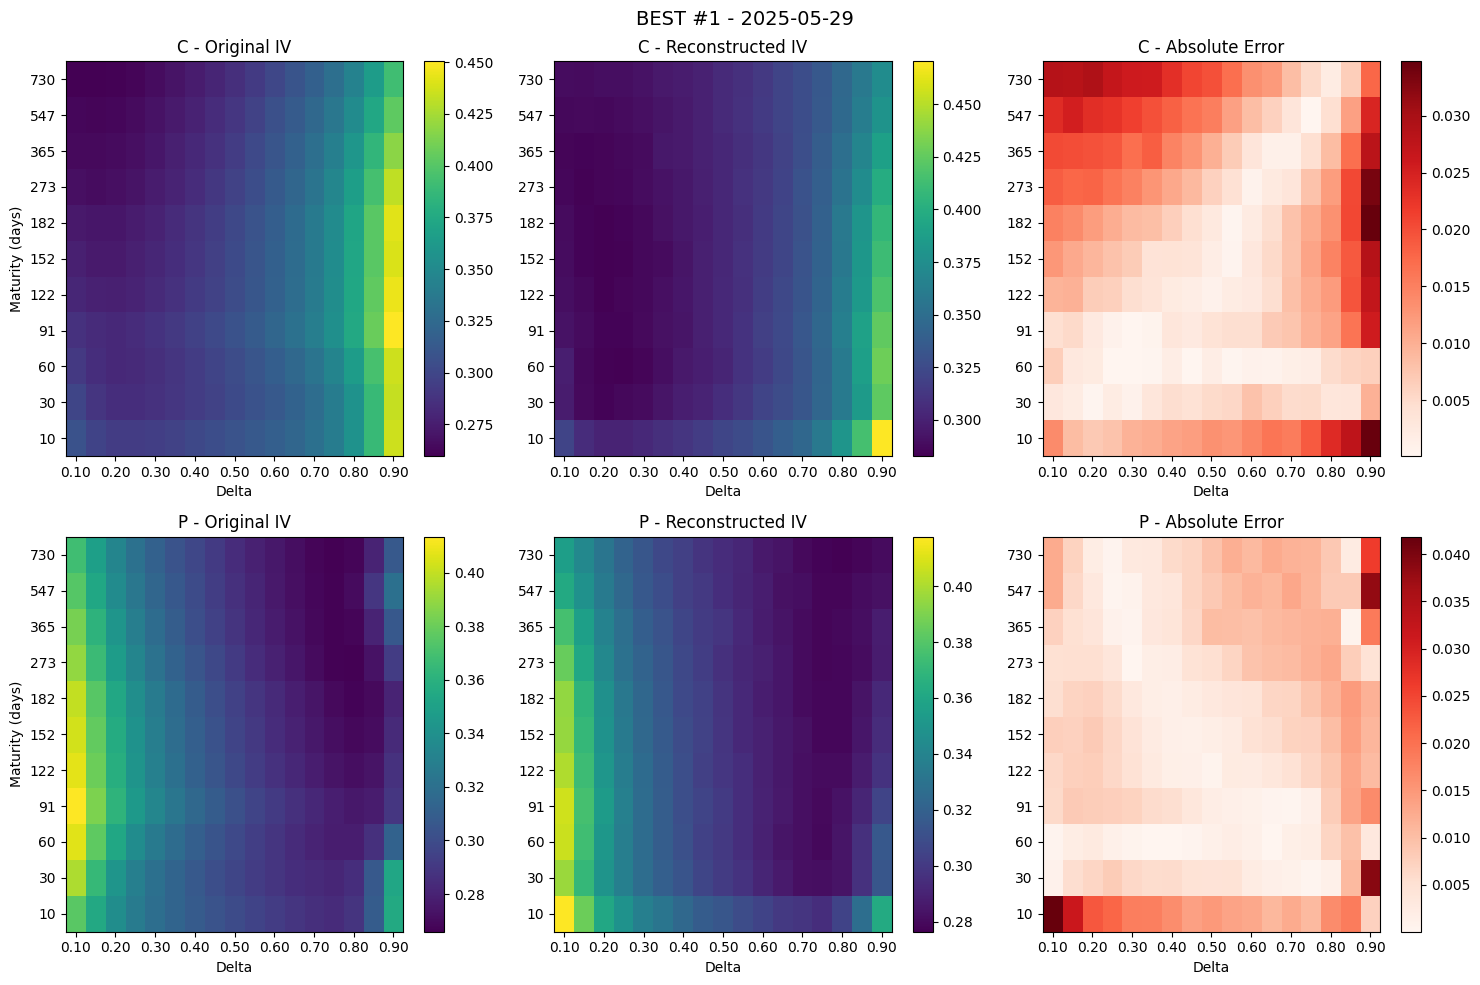

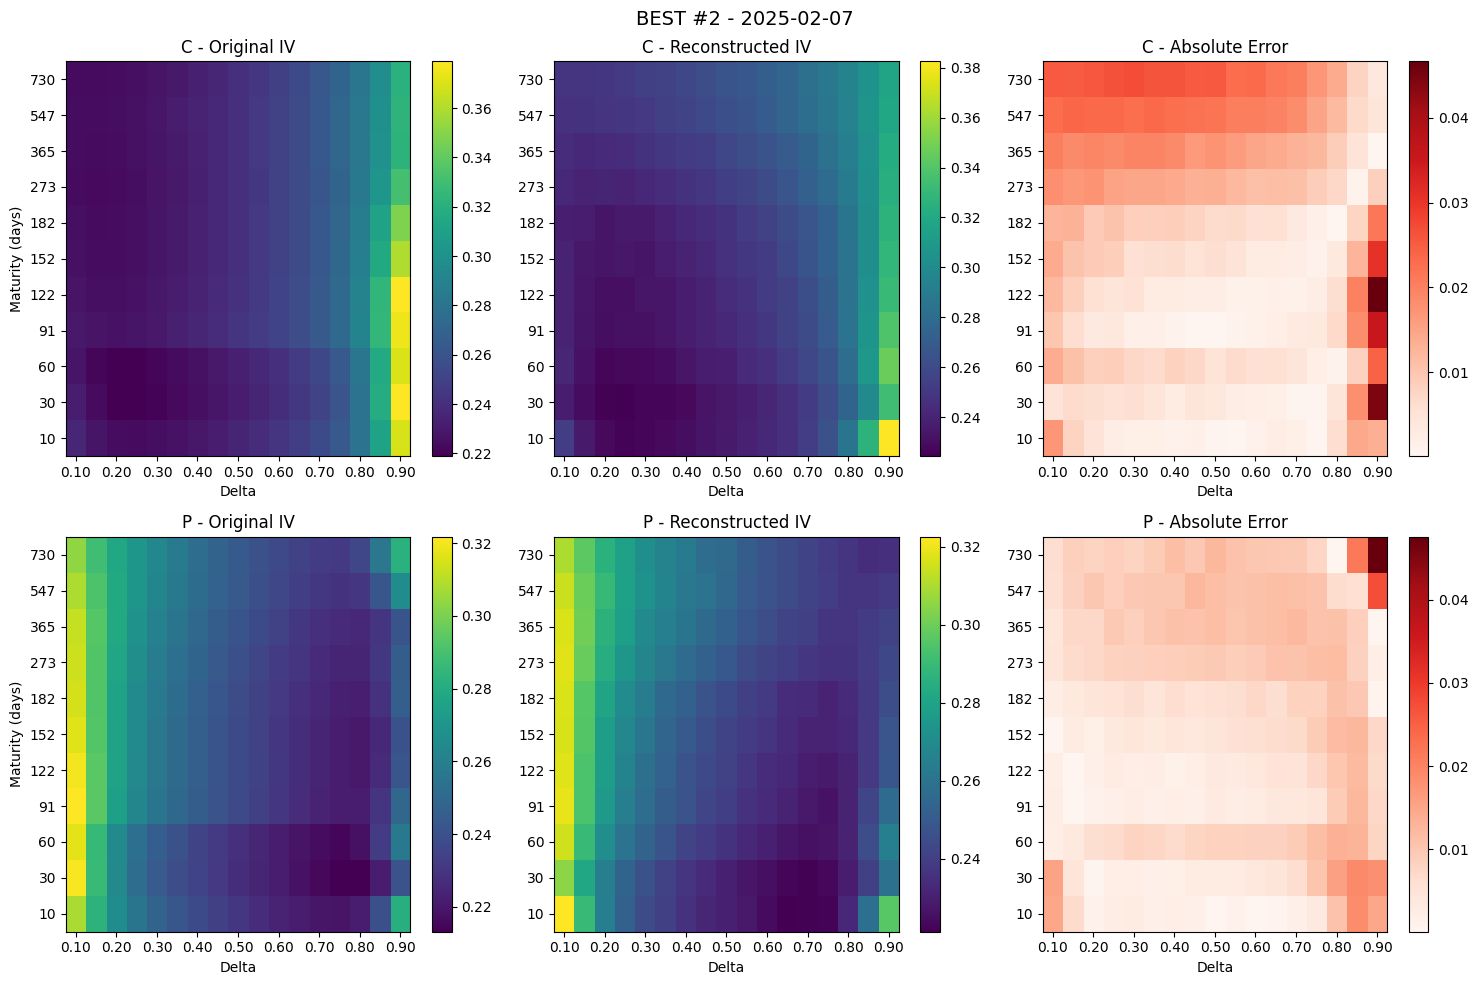

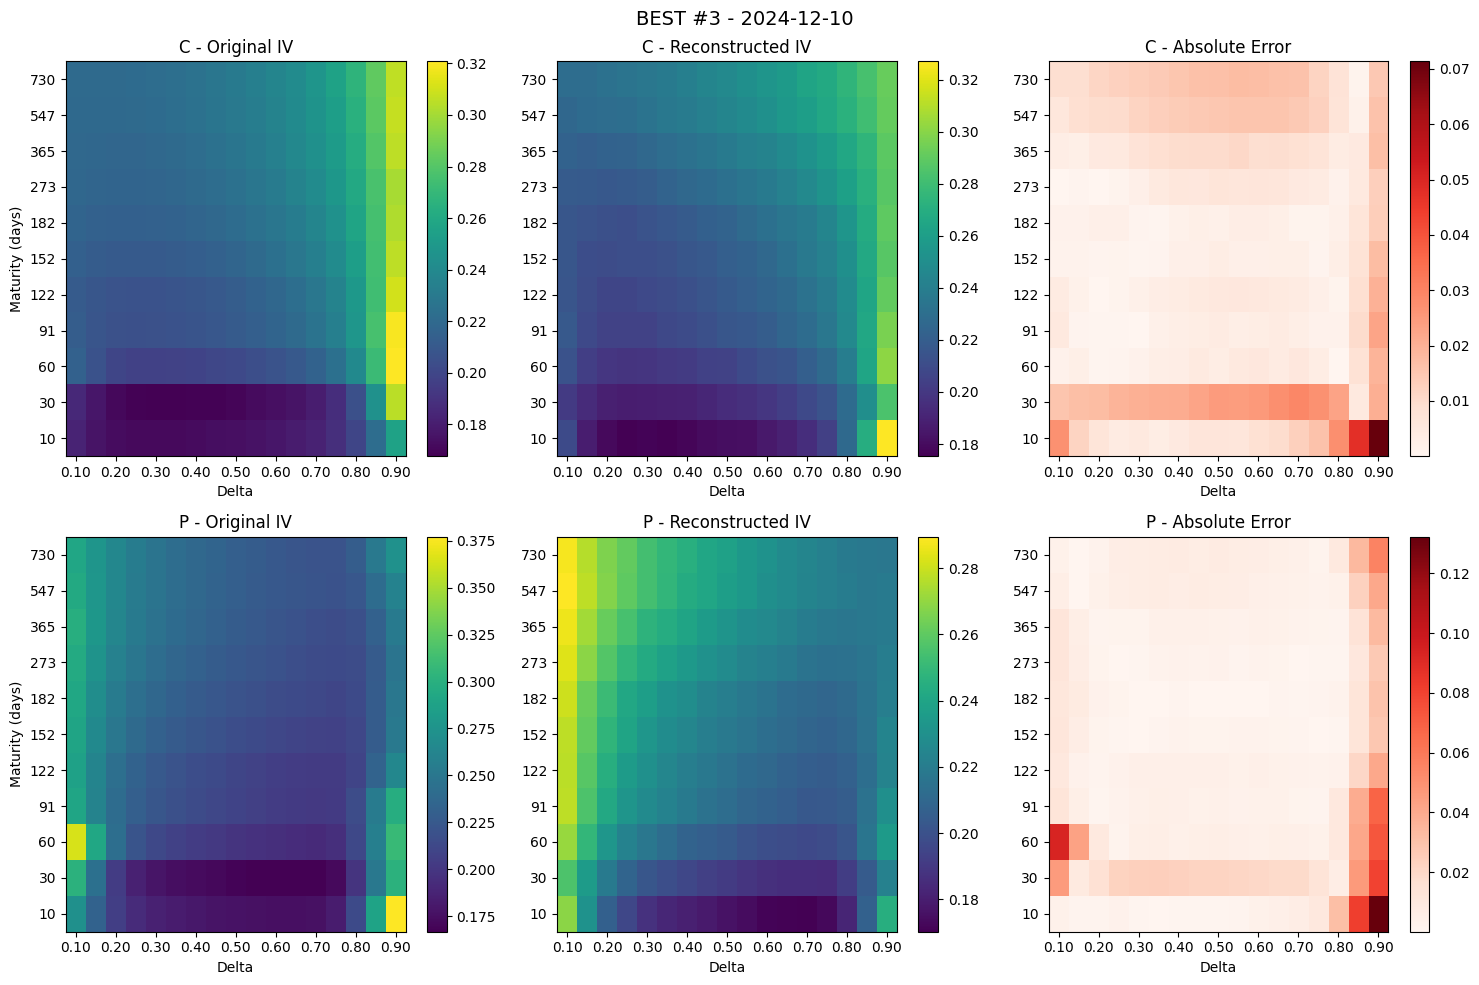

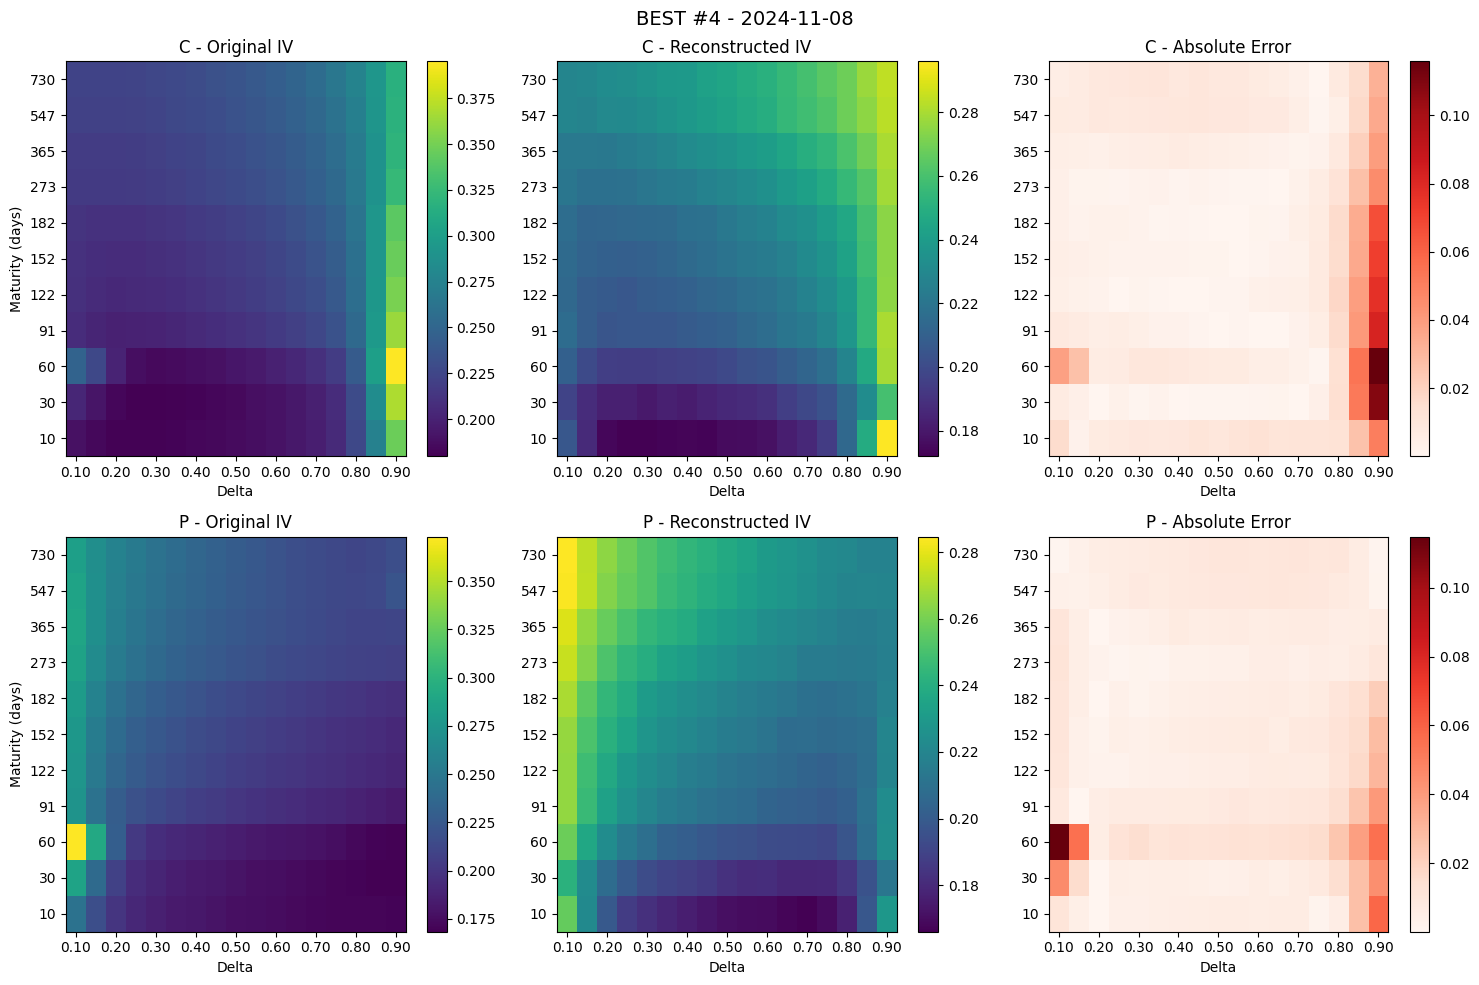

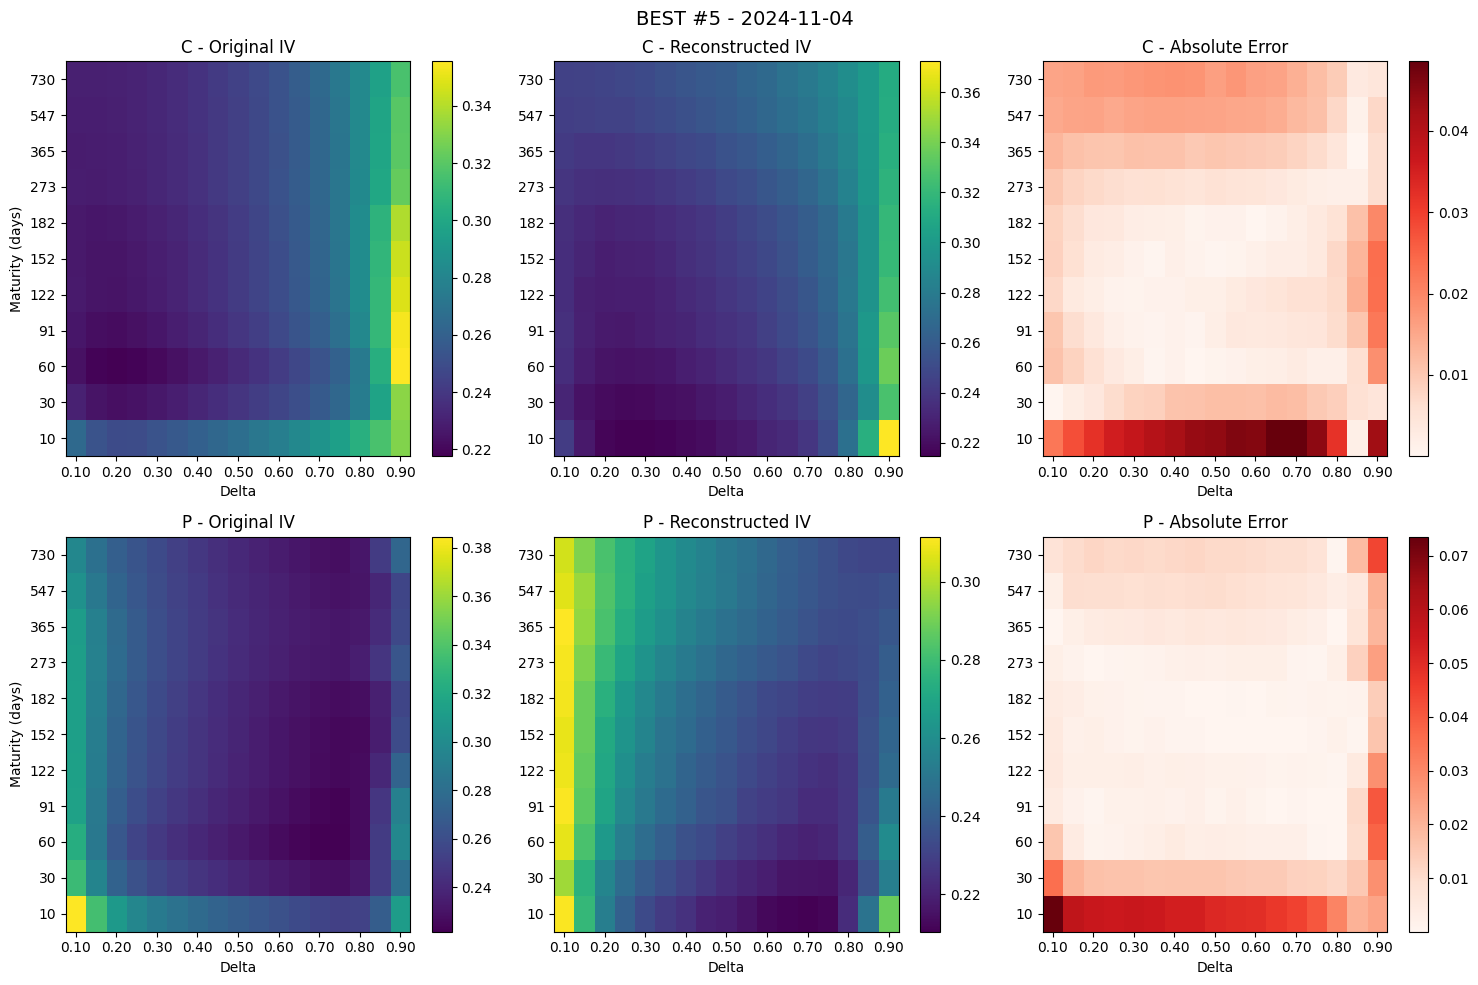

In [14]:
# Plot best reconstructions
for i, idx in enumerate(best_idx):
    date_str = str(result.dates[idx])[:10] if result.dates is not None else f"sample_{idx}"
    fig = plot_surface_comparison(
        target=targets_orig[idx].numpy(),
        recon=recons_orig[idx].numpy(),
        error=errors_orig[idx].numpy(),
        days_grid=days_grid,
        delta_grid=delta_grid,
        cp_order=cp_order,
        title=f"BEST #{i+1} - {date_str}",
    )
    fig.savefig(plots_dir / f"best_{i+1}_{date_str}.png", dpi=150, bbox_inches='tight')
    plt.show()

## 7. Worst Reconstructions

In [15]:
# Get indices of worst reconstructions
worst_idx = get_worst_reconstructions(result, k=N_PLOT_SAMPLES)

print(f"Worst {N_PLOT_SAMPLES} reconstructions (by MSE):")
for i, idx in enumerate(worst_idx):
    date_str = str(result.dates[idx])[:10] if result.dates is not None else f"sample_{idx}"
    mse = torch.mean(result.all_errors[idx] ** 2).item()
    print(f"  {i+1}. {date_str} (MSE: {mse:.6f})")

Worst 5 reconstructions (by MSE):
  1. 2024-11-06 (MSE: 0.740710)
  2. 2025-04-11 (MSE: 0.934303)
  3. 2024-12-31 (MSE: 0.693757)
  4. 2025-07-31 (MSE: 0.536641)
  5. 2025-07-11 (MSE: 0.555065)


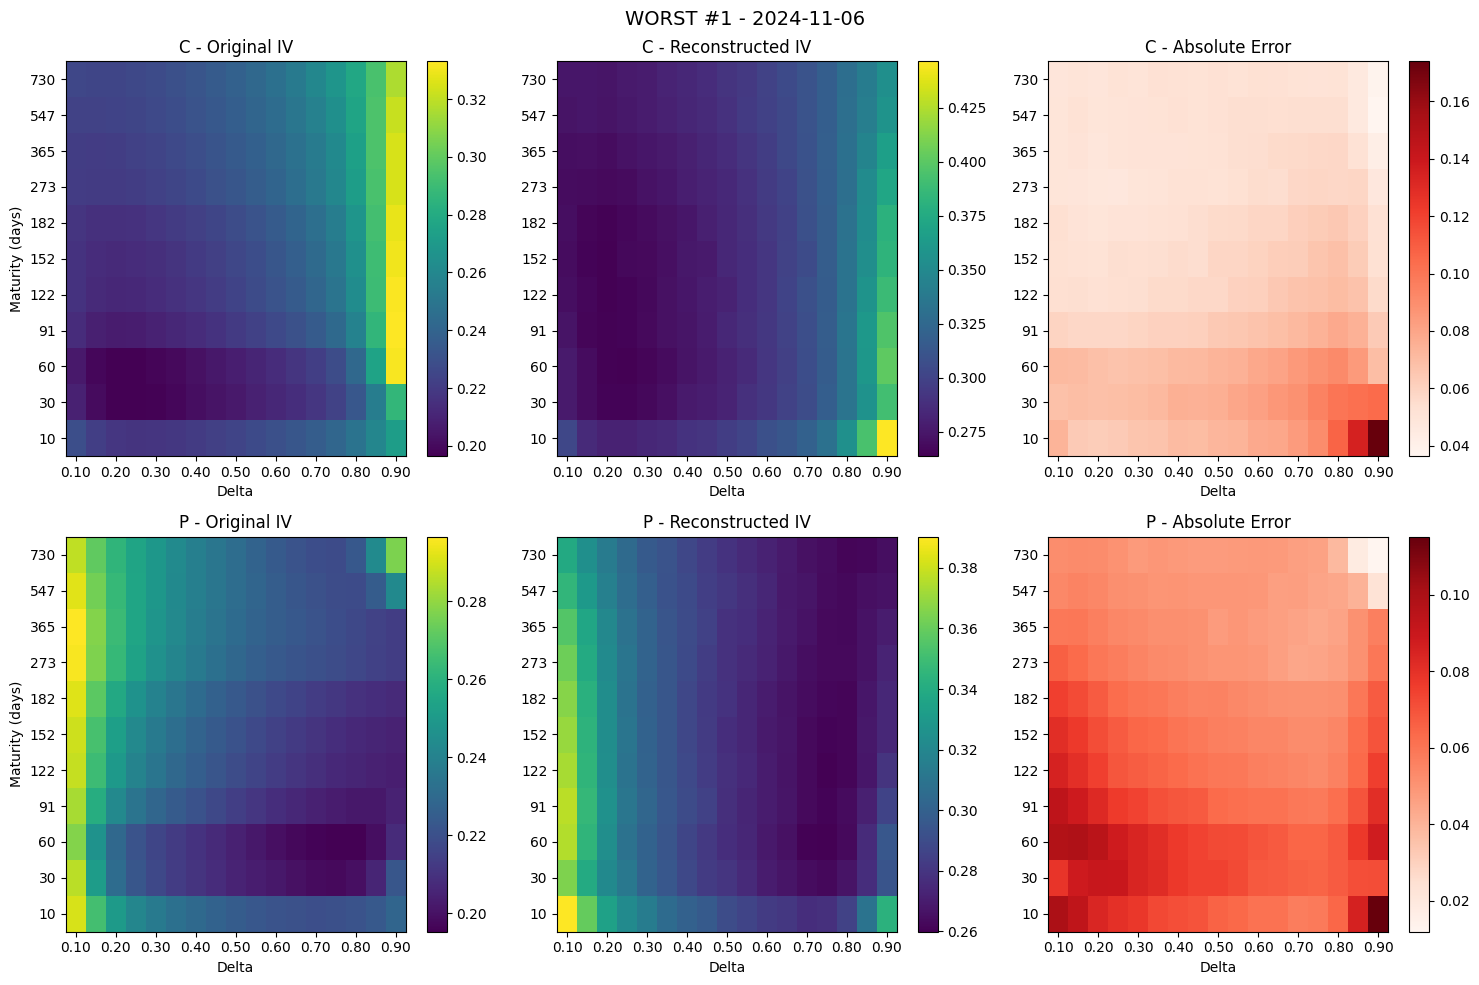

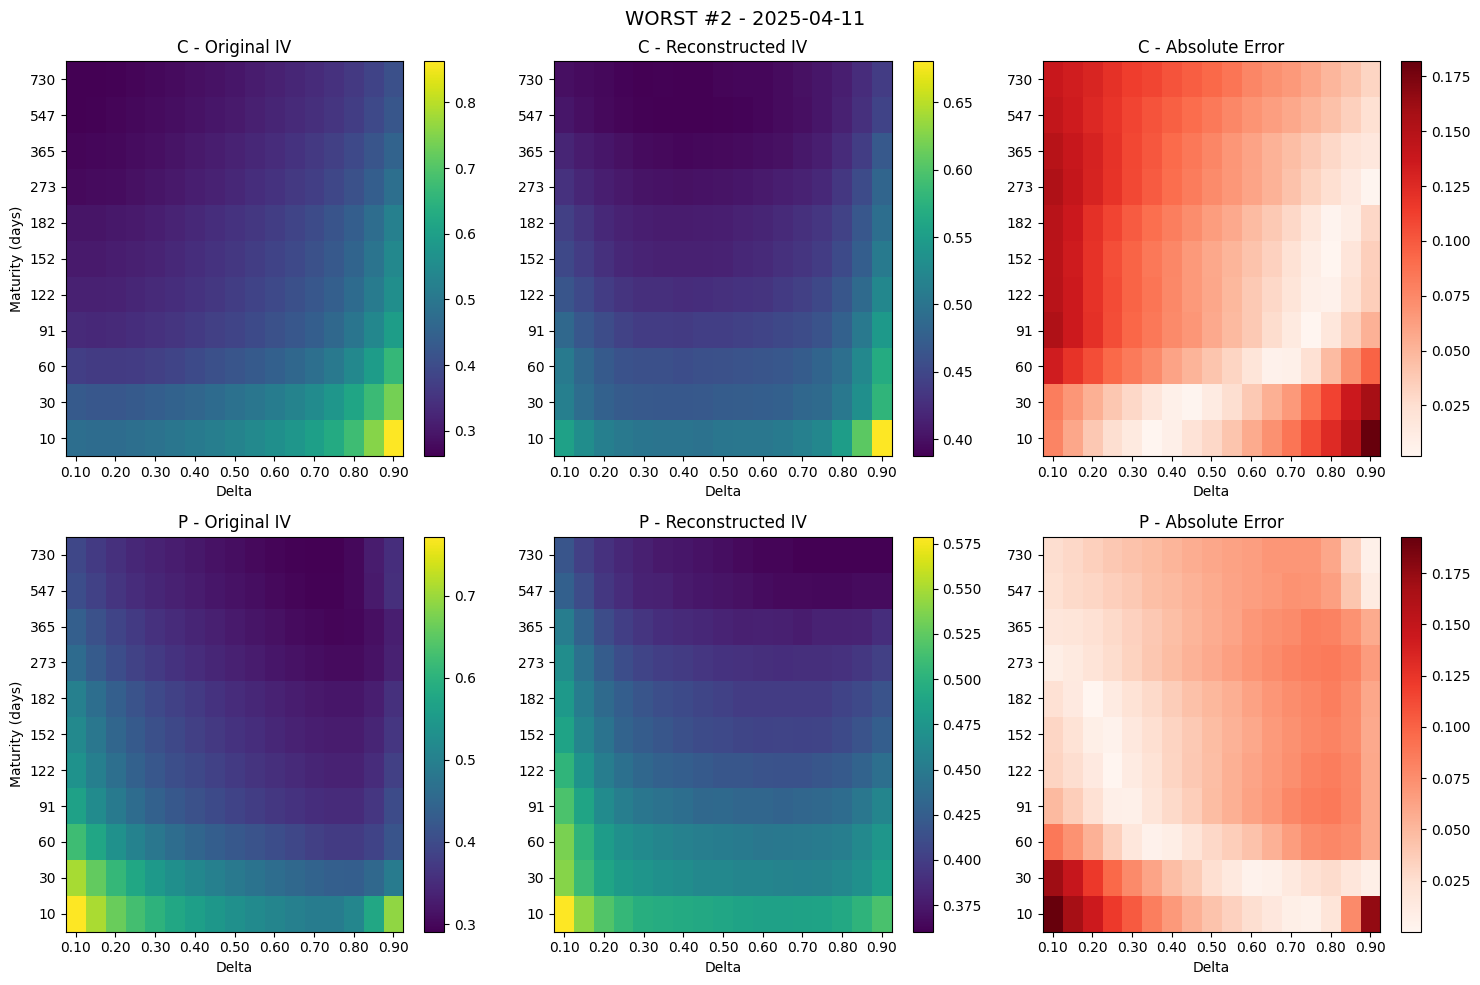

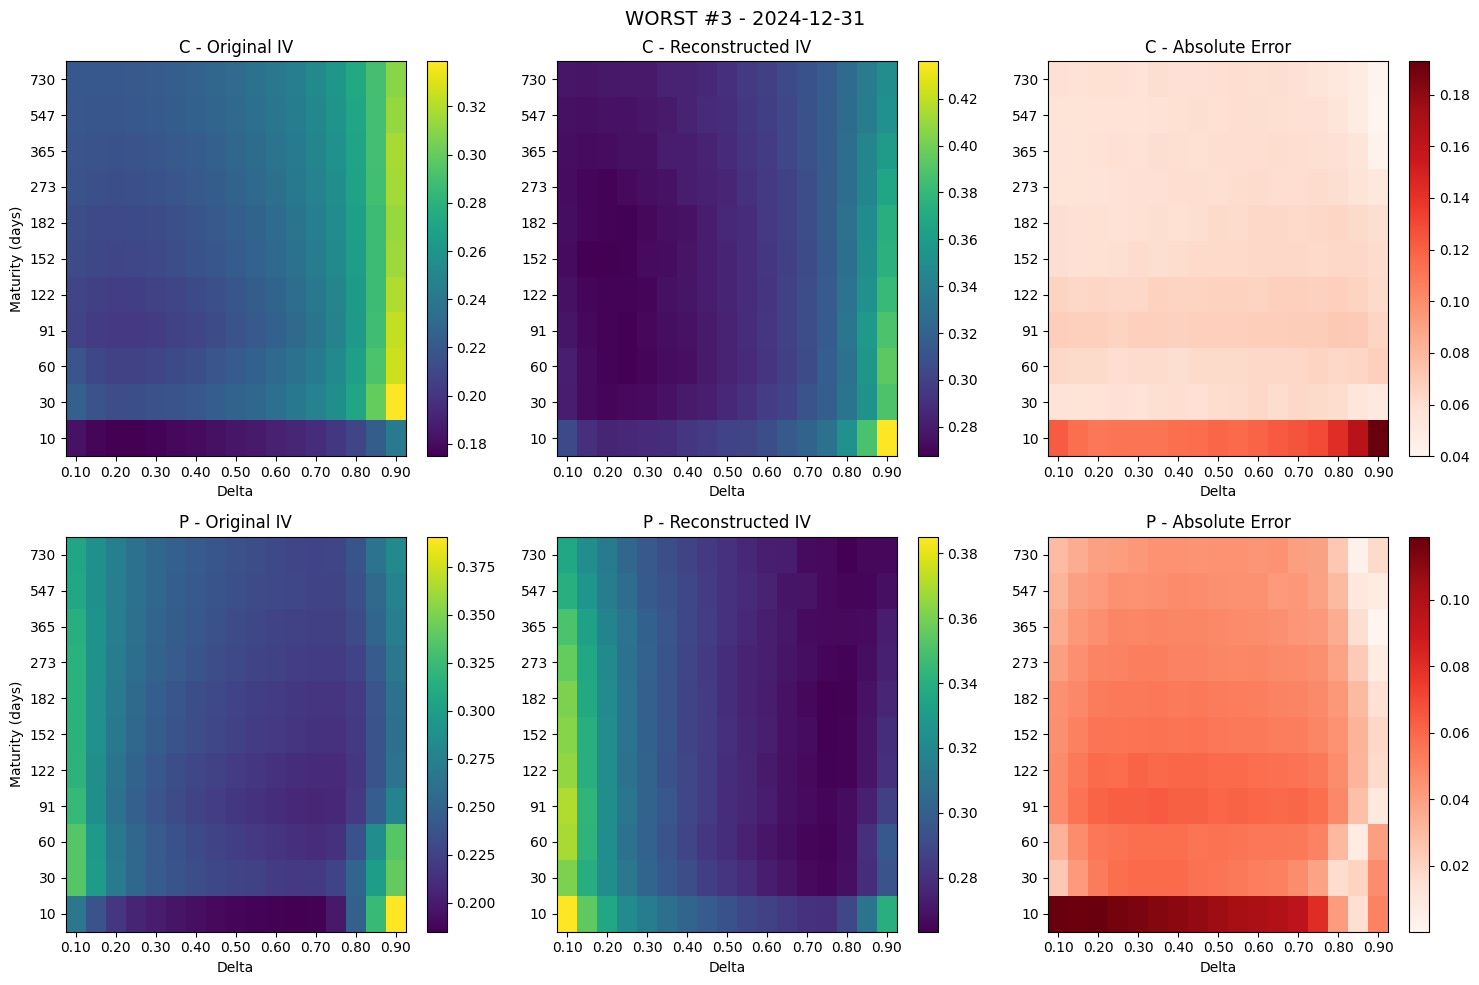

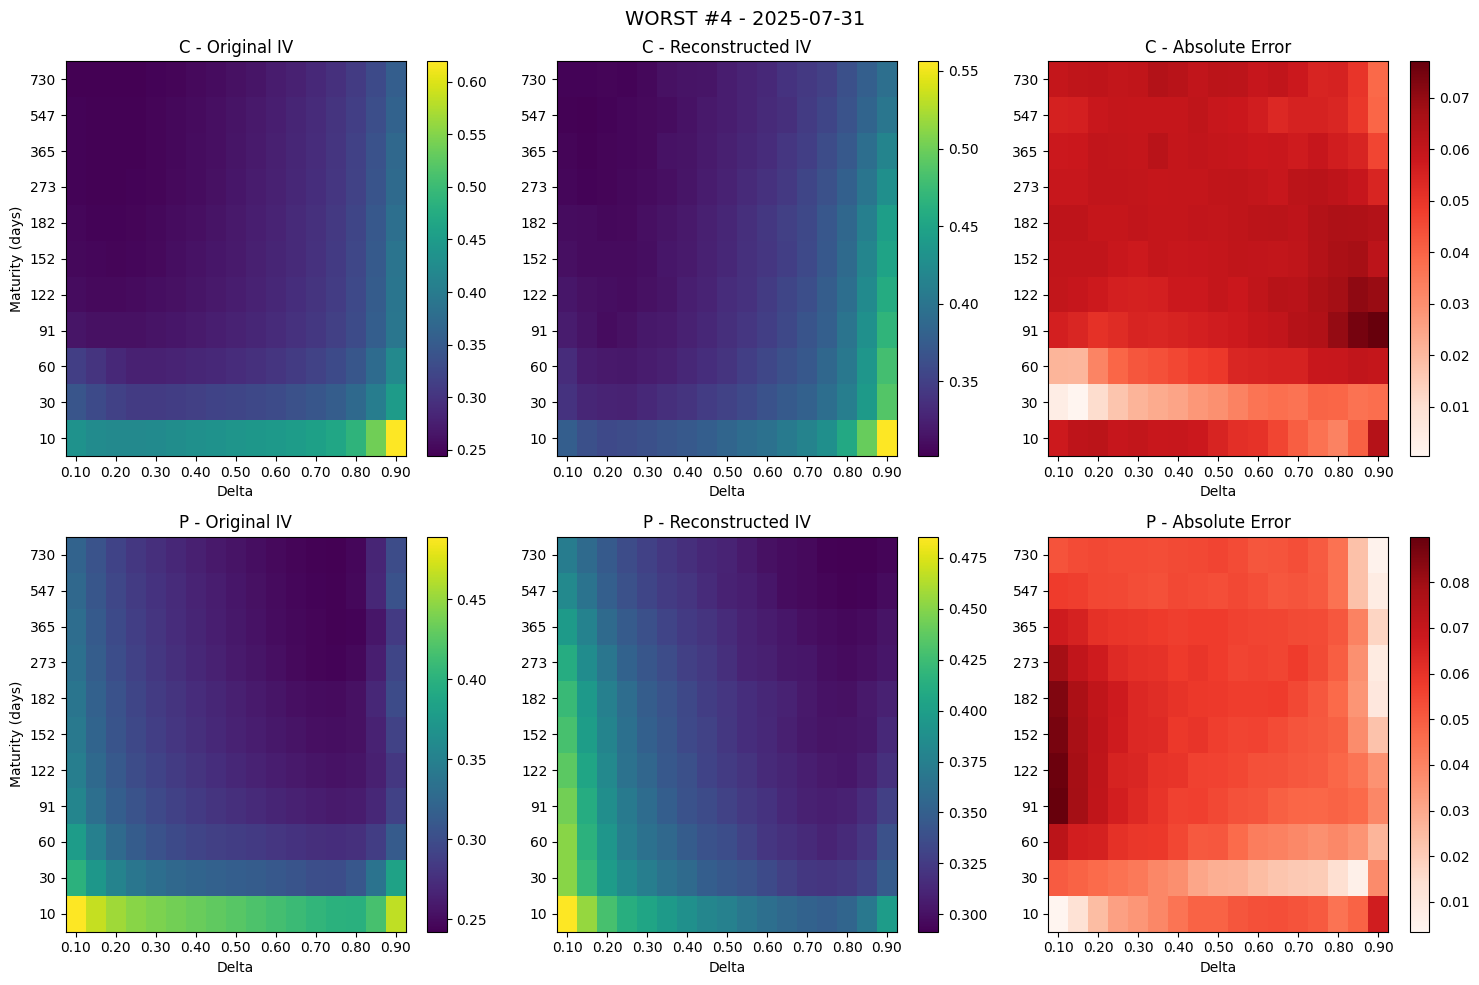

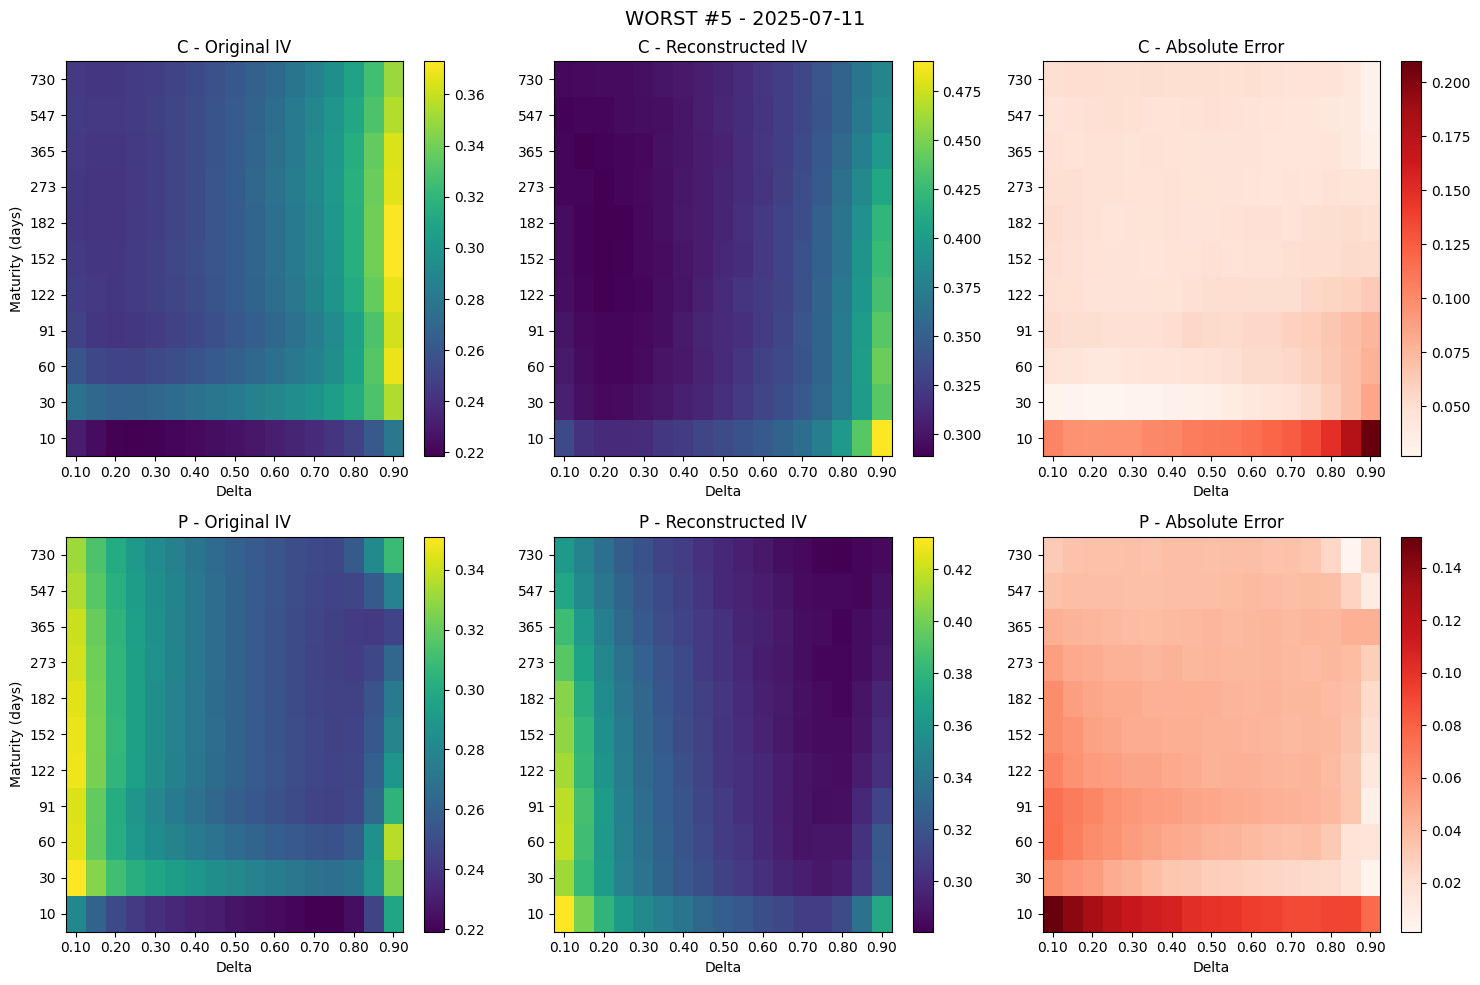

In [16]:
# Plot worst reconstructions
for i, idx in enumerate(worst_idx):
    date_str = str(result.dates[idx])[:10] if result.dates is not None else f"sample_{idx}"
    fig = plot_surface_comparison(
        target=targets_orig[idx].numpy(),
        recon=recons_orig[idx].numpy(),
        error=errors_orig[idx].numpy(),
        days_grid=days_grid,
        delta_grid=delta_grid,
        cp_order=cp_order,
        title=f"WORST #{i+1} - {date_str}",
    )
    fig.savefig(plots_dir / f"worst_{i+1}_{date_str}.png", dpi=150, bbox_inches='tight')
    plt.show()

## 8. Latent Space Visualization

In [17]:
# Extract latent representations
latents = result.all_mus.numpy()
print(f"Latent representations shape: {latents.shape}")

Latent representations shape: (244, 8)


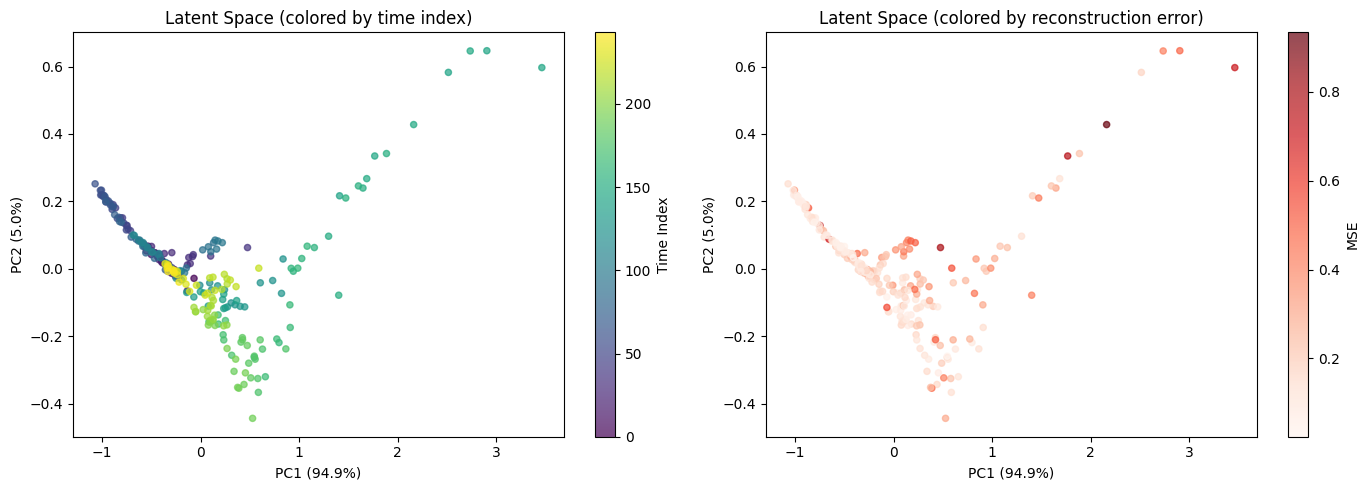

In [18]:
# PCA visualization of latent space
pca = PCA(n_components=2)
latents_2d = pca.fit_transform(latents)

# Color by time (index)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Color by time index
scatter1 = axes[0].scatter(
    latents_2d[:, 0], latents_2d[:, 1],
    c=np.arange(len(latents_2d)), cmap='viridis', alpha=0.7, s=20
)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[0].set_title('Latent Space (colored by time index)')
plt.colorbar(scatter1, ax=axes[0], label='Time Index')

# Plot 2: Color by reconstruction error
per_sample_mse = torch.mean(result.all_errors ** 2, dim=(1, 2, 3)).numpy()
scatter2 = axes[1].scatter(
    latents_2d[:, 0], latents_2d[:, 1],
    c=per_sample_mse, cmap='Reds', alpha=0.7, s=20
)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[1].set_title('Latent Space (colored by reconstruction error)')
plt.colorbar(scatter2, ax=axes[1], label='MSE')

plt.tight_layout()
plt.savefig(plots_dir / "latent_space_pca.png", dpi=150, bbox_inches='tight')
plt.show()

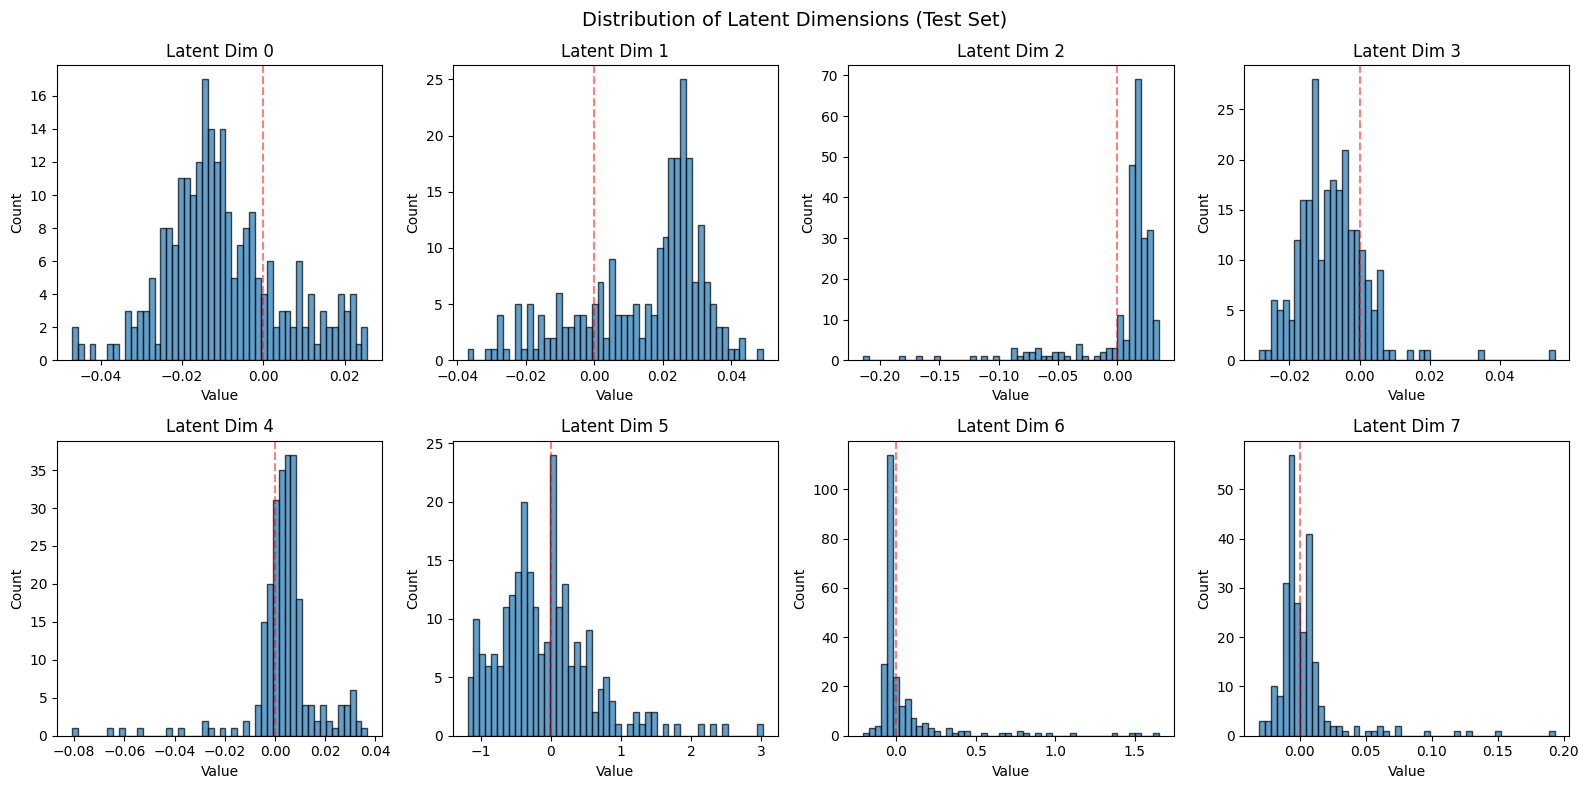

In [19]:
# Latent dimension analysis
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(min(8, latents.shape[1])):
    ax = axes[i // 4, i % 4]
    ax.hist(latents[:, i], bins=50, alpha=0.7, edgecolor='black')
    ax.set_title(f'Latent Dim {i}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)

plt.suptitle('Distribution of Latent Dimensions (Test Set)', fontsize=14)
plt.tight_layout()
plt.savefig(plots_dir / "latent_distributions.png", dpi=150, bbox_inches='tight')
plt.show()

## 9. Error Analysis by Maturity and Delta

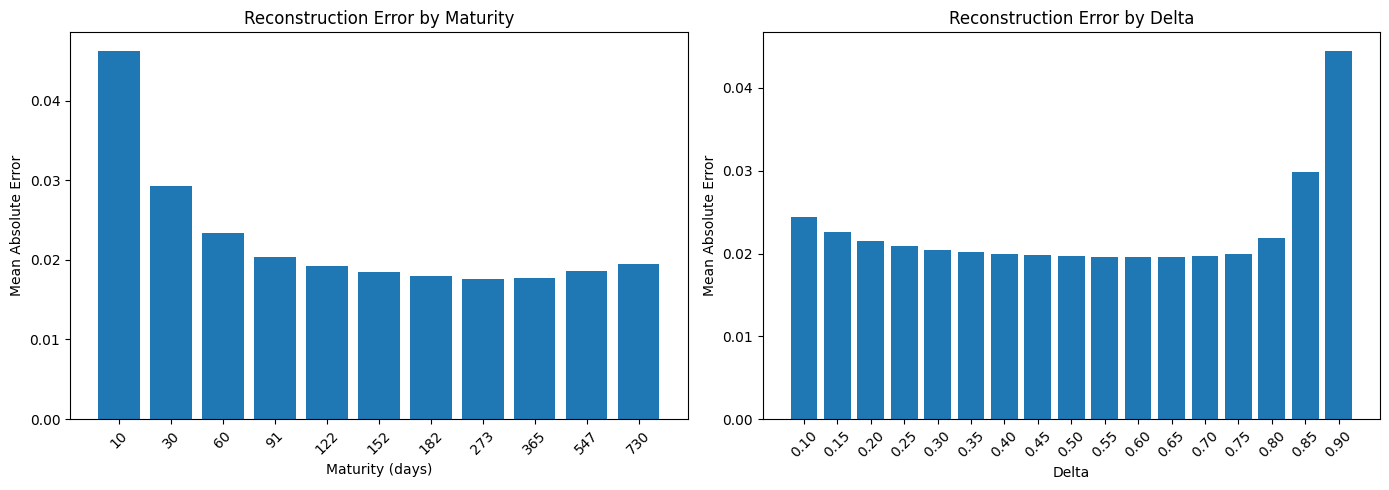

In [20]:
# Analyze error by maturity
mean_error_by_maturity = mean_error.mean(axis=(0, 2))  # Average over CP and delta

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error by maturity
axes[0].bar(range(len(days_grid)), mean_error_by_maturity)
axes[0].set_xlabel('Maturity (days)')
axes[0].set_ylabel('Mean Absolute Error')
axes[0].set_title('Reconstruction Error by Maturity')
axes[0].set_xticks(range(len(days_grid)))
axes[0].set_xticklabels([int(d) for d in days_grid], rotation=45)

# Error by delta
mean_error_by_delta = mean_error.mean(axis=(0, 1))  # Average over CP and maturity
axes[1].bar(range(len(delta_grid)), mean_error_by_delta)
axes[1].set_xlabel('Delta')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].set_title('Reconstruction Error by Delta')
axes[1].set_xticks(range(len(delta_grid)))
axes[1].set_xticklabels([f'{d:.2f}' for d in delta_grid], rotation=45)

plt.tight_layout()
plt.savefig(plots_dir / "error_by_maturity_delta.png", dpi=150, bbox_inches='tight')
plt.show()

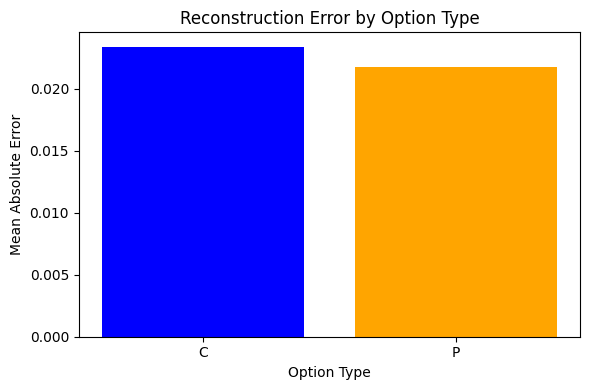


Mean Absolute Error by option type:
  C: 0.023398 (2.34% vol)
  P: 0.021772 (2.18% vol)


In [21]:
# Error by call/put
mean_error_by_cp = mean_error.mean(axis=(1, 2))  # Average over maturity and delta

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(cp_order, mean_error_by_cp, color=['blue', 'orange'])
ax.set_xlabel('Option Type')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Reconstruction Error by Option Type')
plt.tight_layout()
plt.show()

print(f"\nMean Absolute Error by option type:")
for i, cp in enumerate(cp_order):
    print(f"  {cp}: {mean_error_by_cp[i]:.6f} ({mean_error_by_cp[i]*100:.2f}% vol)")

## 10. Error Time Series

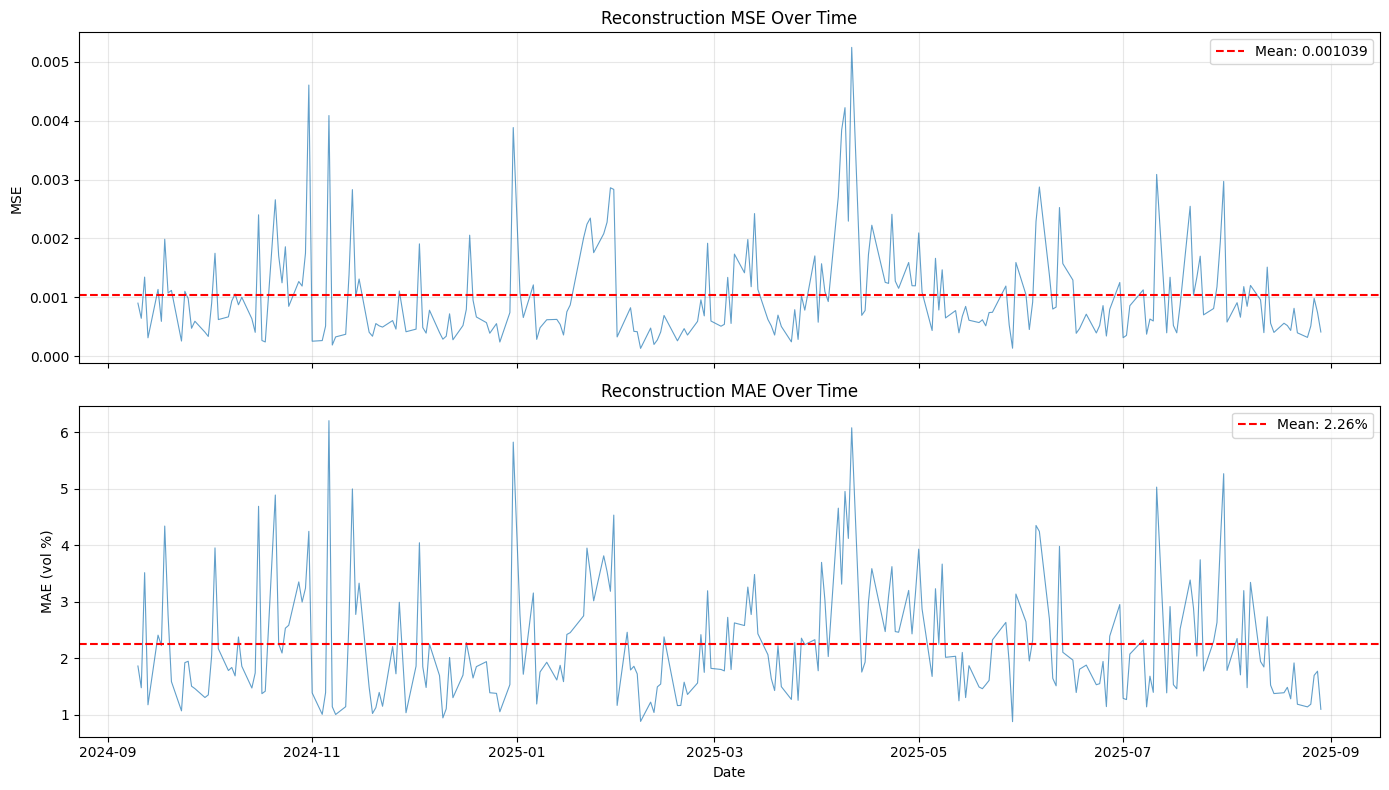

In [22]:
# Per-sample MSE over time
per_sample_mse = torch.mean(errors_orig ** 2, dim=(1, 2, 3)).numpy()
per_sample_mae = torch.mean(errors_orig, dim=(1, 2, 3)).numpy()

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

if result.dates is not None:
    dates = pd.to_datetime(result.dates)
    x = dates
else:
    x = np.arange(len(per_sample_mse))

axes[0].plot(x, per_sample_mse, alpha=0.7, linewidth=0.8)
axes[0].axhline(y=np.mean(per_sample_mse), color='red', linestyle='--', label=f'Mean: {np.mean(per_sample_mse):.6f}')
axes[0].set_ylabel('MSE')
axes[0].set_title('Reconstruction MSE Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(x, per_sample_mae * 100, alpha=0.7, linewidth=0.8)  # Convert to vol %
axes[1].axhline(y=np.mean(per_sample_mae * 100), color='red', linestyle='--', label=f'Mean: {np.mean(per_sample_mae)*100:.2f}%')
axes[1].set_ylabel('MAE (vol %)')
axes[1].set_xlabel('Date' if result.dates is not None else 'Sample Index')
axes[1].set_title('Reconstruction MAE Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(plots_dir / "error_time_series.png", dpi=150, bbox_inches='tight')
plt.show()

## 11. Save Outputs for Heston Comparison

In [23]:
# Save latent representations
latent_path = output_dir / "test_latents.pt"
torch.save({
    "mus": result.all_mus,
    "dates": result.dates,
}, latent_path)
print(f"Latent representations saved to: {latent_path}")

Latent representations saved to: ..\..\artifacts\eval\test_latents.pt


In [24]:
# Save VAE reconstructed surfaces for comparison with Heston
# Format: [N, C, H, W] in original IV space
vae_surfaces = recons_orig.numpy()
surfaces_path = surfaces_dir / "vae_surfaces.npy"
np.save(surfaces_path, vae_surfaces)
print(f"VAE surfaces saved to: {surfaces_path}")
print(f"  Shape: {vae_surfaces.shape} (N, C, H, W)")

VAE surfaces saved to: ..\..\artifacts\eval\surfaces\vae_surfaces.npy
  Shape: (244, 2, 11, 17) (N, C, H, W)


In [25]:
# Save dates for matching with Heston
dates_df = pd.DataFrame({"date": result.dates})
dates_path = surfaces_dir / "vae_surface_dates.csv"
dates_df.to_csv(dates_path, index=False)
print(f"Dates saved to: {dates_path}")
print(f"  {len(result.dates)} dates total")

Dates saved to: ..\..\artifacts\eval\surfaces\vae_surface_dates.csv
  244 dates total


In [26]:
# Save original market surfaces for comparison
target_surfaces = targets_orig.numpy()
targets_path = surfaces_dir / "market_surfaces.npy"
np.save(targets_path, target_surfaces)
print(f"Market surfaces saved to: {targets_path}")

Market surfaces saved to: ..\..\artifacts\eval\surfaces\market_surfaces.npy


In [27]:
# Save grid spec for reference
grid_spec_info = {
    "days_grid": days_grid.tolist(),
    "delta_grid": delta_grid.tolist(),
    "cp_order": list(cp_order),
    "shape": list(vae_surfaces.shape),
}
grid_path = surfaces_dir / "grid_spec.json"
with open(grid_path, "w") as f:
    json.dump(grid_spec_info, f, indent=2)
print(f"Grid spec saved to: {grid_path}")

Grid spec saved to: ..\..\artifacts\eval\surfaces\grid_spec.json


## 12. Summary

In [28]:
print("\n" + "=" * 60)
print("EVALUATION COMPLETE")
print("=" * 60)

print(f"\nTest Set Performance:")
print(f"  MSE (original IV):  {metrics.mse_original:.6f}")
print(f"  MAE (original IV):  {metrics.mae_original:.6f}")
print(f"  MAE (vol points):   {metrics.mae_original * 100:.2f}%")

print(f"\nOutputs saved to: {output_dir}")
print(f"  - test_metrics.json")
print(f"  - test_latents.pt")
print(f"  - plots/")
for f in plots_dir.glob("*.png"):
    print(f"      - {f.name}")
print(f"  - surfaces/")
print(f"      - vae_surfaces.npy")
print(f"      - market_surfaces.npy")
print(f"      - vae_surface_dates.csv")
print(f"      - grid_spec.json")

print(f"\n✓ Ready for Heston comparison!")
print(f"  Next step: Run heston_calibration.ipynb on test dates,")
print(f"  then run compare_vae_heston.ipynb")


EVALUATION COMPLETE

Test Set Performance:
  MSE (original IV):  0.001039
  MAE (original IV):  0.022585
  MAE (vol points):   2.26%

Outputs saved to: ..\..\artifacts\eval
  - test_metrics.json
  - test_latents.pt
  - plots/
      - best_1_2025-05-29.png
      - best_2_2025-02-07.png
      - best_3_2024-12-10.png
      - best_4_2024-11-08.png
      - best_5_2024-11-04.png
      - error_by_maturity_delta.png
      - error_time_series.png
      - latent_distributions.png
      - latent_space_pca.png
      - mean_error_heatmap.png
      - worst_1_2024-11-06.png
      - worst_2_2025-04-11.png
      - worst_3_2024-12-31.png
      - worst_4_2025-07-31.png
      - worst_5_2025-07-11.png
  - surfaces/
      - vae_surfaces.npy
      - market_surfaces.npy
      - vae_surface_dates.csv
      - grid_spec.json

✓ Ready for Heston comparison!
  Next step: Run heston_calibration.ipynb on test dates,
  then run compare_vae_heston.ipynb
